### An algorithm to find numerical solution to the final state of an Ising chain with Hamiltonian, ###     
### $$ \begin{align} H = \sum_{i<j}^{n} \left [- \frac{1}{2 \left | i-j \right |}\sigma_{i}^{x}\sigma_{j}^{x} -\frac{1}{2}\sigma_{j}^{x} - \frac{1}{2}\sigma_{j}^{z}\right ] \end{align} $$
### where i<j and the interaction $J_{ij} = \frac{1}{\left | i-j \right |}$. ###

In [1]:
from pyquil import Program, get_qc
from pyquil.gates import *
import numpy as np,os
import math
from scipy.linalg import expm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook,tqdm
from itertools import permutations 
from itertools import combinations
from pyquil.paulis import trotterize
from pyquil.paulis import ID, sX, sY, sZ,ID
from pyquil.gates import CNOT, Z, X, Y, H, RZ, RX
from pyquil.api import local_qvm
from pyquil.api import WavefunctionSimulator
#return exact matrix form for the Pauli sum
from pyquil.unitary_tools import lifted_pauli 
from pyquil.paulis import PauliSum
output_dir = 'Ising Chain Simu'
if not os.path.exists(output_dir): os.makedirs(output_dir)
pauli_x = [sX(0),sX(1),sX(2),sX(3),sX(4),sX(5),sX(6),sX(7),sX(8)]
pauli_z = [sZ(0),sZ(1),sZ(2),sZ(3),sZ(4),sZ(5),sZ(6),sZ(7),sZ(8)]

In [2]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]
# Prints: [6.0, 4.0]
print("Current size:", fig_size)
# Set figure width to 11 and height to 8
fig_size[0] = 11
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

Current size: [6.0, 4.0]


In [3]:
def convert_row(x,n):
    '''Definition of a function to convert the output
       vector from PyQuil to a ROW vector, this function
       shall be used for writing final state data.
       param x: an output vector.
       param n: number of qubits.'''
    vector = []
    for i in np.arange(2**n):
        key = x[i]
        vector.append(key)
    return vector

In [4]:
def ini_state(n):
    '''Definition of a function to generate an initial state
       |00...00> for n qubits.
       param n: numble of qubits'''
    state = 1
    for i in np.arange(n):
        up_col = np.array([[1],[0]])
        state = np.kron(state,up_col)
    return state

In [5]:
def convert_col(x,n):
    '''Definition of a function to convert the output
       vector from PyQuil to a COLUMN vector, this function
       shall be used for reading final state data.
       param x: an output vector.
       param n: number of qubits.'''
    vector = []
    for i in np.arange(2**n):
        key = x[i]
        vector.append([key])
    return vector

In [6]:
def fidelity(x,y):
    '''Definition of fidelity calculation of vector x and y
       param x: input column vector 1
       param y: input co;lumn vector 2
       function returns a fidility value between 0 and 1'''
    #create some initial values for later iteration of addition
    norm_x = 0
    norm_y = 0
    #loops to compute normalisation constants for both vector x
    #and y respectively
    for i in np.arange(len(x)):
        norm_x = norm_x + abs(x[i,0])**2
    for i in np.arange(len(y)):
        norm_y = norm_y + abs(y[i,0])**2
    #now normalise the vectors
    x_norm = x/np.sqrt(norm_x)
    y_norm = y/np.sqrt(norm_y)
    #compute Hermitian conjugate of vector x
    x_norm_trans = np.matrix.conjugate(x_norm.transpose())
    #compute inner product of vector x and y
    inner_pro = x_norm_trans.dot(y_norm)
    #to obtain a value for the fidility
    fid = (abs(inner_pro)[0,0])**2
    return fid

In [7]:
def intera_J(n):
    '''Definition of a function to compute the interaction
       between site i and j and return a list of value for 
       1/|i-j|
       param n: number of qubits (system size).
       output: an array of interaction strength values for
       each coupling term.
       '''
    index = np.array(list(combinations(range(n),2)))
    no_of_comb = len(index)
    #collect values for interaction strength to form a list
    lis = []
    for i in np.arange(no_of_comb):
        diff = abs(index[i,0] - index[i,1])
        factor = 1.0/diff
        lis.append(factor)
    lis_factor = np.array(lis)
    return lis_factor

In [8]:
def comb_xx(n):
    '''Definition of a function to find all combinations 
       of the Pauli terms in the XX part of the Ising-like 
       Hamiltonian for n qubits to be digitally simulated. 
       Each of the terms is of the form sX(i)*sX(j).
       param n: number of qubits.
       output: an array of all Paulis terms.'''
    index = np.array(list(combinations(range(n),2)))
    no_of_comb = len(index)
    comb_xx = []
    for i in np.arange(no_of_comb):
        key1 = index[i][0]
        key2 = index[i][1]
        comb_xx.append(pauli_x[key1]*pauli_x[key2]*intera_J(n)[i])
    return comb_xx

In [9]:
def comb_z(n):
    '''Definition of a function to find all combinations 
       of the Pauli terms in the field interaction along 
       z direction part of the Ising-like Hamiltonian for 
       n qubits to be digitally simulated. Each of the 
       terms is of the form sZ(j).
       param n: number of qubits.
       output: an array of all Pauli Z terms.'''
    index = np.array(list(combinations(range(n),2)))
    no_of_comb = len(index)
    comb_z = []
    for i in np.arange(no_of_comb):
        key = index[i][1]
        comb_z.append(pauli_z[key])
    return comb_z

In [10]:
def comb_x(n):
    '''Definition of a function to find all combinations 
       of the Pauli terms in the field interaction along 
       x direction part of the Ising-like Hamiltonian for 
       n qubits to be digitally simulated. Each of the 
       terms is of the form sX(j).
       param n: number of qubits.
       output: an array of all Pauli Z terms.'''
    index = np.array(list(combinations(range(n),2)))
    no_of_comb = len(index)
    comb_x = []
    for i in np.arange(no_of_comb):
        key = index[i][1]
        comb_x.append(pauli_x[key])
    return comb_x

### ${\color{Blue}{\mathit{\text{Part I i):}}}}$ The classical analogue simulation.

In [11]:
def theo_Hamil(n,t):
    '''Difinition of a function to compute and return theoretical
       Hamiltonian for n qubits with (choosing-2-out-of-n) 
       coupling terms in matrix form for evolution time t.
       param n: number of qubits.
       param t: total evolution time'''
    factor = 0.5
    # number of combination for n qubits
    length = np.arange(len(comb_xx(n)))
    # compute the xx interaction part of the Hamiltonian
    part_xx = [comb_xx(n)[i]*t*factor for i in length]
    # compute the x field interaction part of the Hamiltonian
    part_x = [x*factor*t for x in comb_x(n)]
    # compute the z field interaction part of the Hamiltonian
    part_z = [x*factor*t for x in comb_z(n)]
    # sum up all Pauli terms in the part_xx
    pauli_sum_xx = PauliSum(part_xx)
    # sum up all Pauli terms in the part_x
    pauli_sum_x = PauliSum(part_x)
    # sum up all Pauli terms in the part_z
    pauli_sum_z = PauliSum(part_z)
    # acquire a list of qubit indices for the applied 
    # Pauli operators
    list_qbt = PauliSum.get_qubits(pauli_sum_xx)
    # add up the final matrices of both the pauli_xx
    # pauli_z to obtain the Hamiltonian in its matrix
    # form
    Hamil = lifted_pauli(pauli_sum_xx,list_qbt) + lifted_pauli(pauli_sum_z,list_qbt) \
            + lifted_pauli(pauli_sum_x,list_qbt)
    return Hamil

In [12]:
n = 2  # no of qubits
t = 0.1 # evolution time
theo_9qbt = expm(1j*theo_Hamil(n,t)).dot(ini_state(n))

### ${\color{Blue}{\mathit{\text{Part I: ii)}}}}$ The virtual digital simulation.

#### The first order Trotter approximant to $e^{t(A+B+C)}$  is given by, ###
### $e^{t(A+B+C)} = e^{t(A+B)}e^{tC} = e^{tA}e^{tB}e^{tC}$. ###
#### We let $A = \sigma^{x}\sigma^{x}, B = \sigma^{x}, C = \sigma^{z}$. Obviously, operators A and B are mutually commutative and therefore they are seperable.  ###

In [13]:
def Ising_prog_1(n,t):
    '''Definition of a function to obtain a sequence of gates
       for an Ising chain with H = -0.5*(1/|i-j|)*sigma_x_i*sigma_x_j 
       - 0.5*sigma_x_j - 0.5*sigma_z_j where index i j run from 0th 
       to (n-1)th site and i is always smaller than j. Here 1st-order
       Trotter approximant is applied. 
       param n: number of qubits (n>=2).
       param t: evolution time.'''
    from pyquil.paulis import exponentiate
    factor = -0.5
    prog = Program()
    # The coefficients of exponential operators
    for i in np.arange(len(comb_xx(n))):
        prog_ini = Program()
        prog_ini += trotterize(t*factor*comb_xx(n)[i],t*factor*comb_x(n)[i],trotter_order=1)
        prog_ini += exponentiate(t*factor*comb_z(n)[i])
        prog += prog_ini
    return prog

#### The second order Trotter approximant to $e^{t(A+B+C)}$  is given by, ###
### $e^{t(A+B+C)} = e^{\frac{t}{2}(A+B)}e^{tC}e^{\frac{t}{2}(A+B)} = e^{\frac{t}{2}A}e^{\frac{t}{2}B}e^{tC}e^{\frac{t}{2}A}e^{\frac{t}{2}B} $. ###
#### We let $A = \sigma^{x}\sigma^{x}, B = \sigma^{x}, C = \sigma^{z}$. Obviously, operators A and B are mutually commutative and therefore they are seperable.  ###

In [14]:
def Ising_prog_2(n,t):
    '''Definition of a function to obtain a sequence of gates
       for an Ising chain with H = -0.5*(1/|i-j|)*sigma_x_i*sigma_x_j 
       - 0.5*sigma_x_j - 0.5*sigma_z_j where index i j run from 0th 
       to (n-1)th site and i is always smaller than j. Here 2nd-order
       Trotter approximant is applied. 
       param n: number of qubits (n>=2).
       param t: evolution time.'''
    from pyquil.paulis import exponentiate
    factor = -0.5
    prog = Program()
    # The coefficients of exponential operators
    coef_lis = [1/2,1,1/2]
    for i in np.arange(len(comb_xx(n))):
        prog_ini = Program()
        prog_ini += trotterize(t*factor*coef_lis[0]*comb_xx(n)[i],t*factor*coef_lis[0]*comb_x(n)[i],trotter_order=2)
        prog_ini += exponentiate(t*factor*coef_lis[1]*comb_z(n)[i])
        prog_ini += trotterize(t*factor*coef_lis[2]*comb_xx(n)[i],t*factor*coef_lis[2]*comb_x(n)[i],trotter_order=2)
        prog += prog_ini
    return prog

#### The third order Trotter approximant to $e^{t(A+B+C)}$  is given by, ###
### $e^{t(A+B+C)} = e^{\frac{7}{24}t(A+B)}e^{\frac{2}{3}tC}e^{\frac{3}{4}t(A+B)}e^{-\frac{2}{3}tC}e^{-\frac{1}{24}t(A+B)}e^{tC} $. ###
#### We let $A = \sigma^{x}\sigma^{x}, B = \sigma^{x}, C = \sigma^{z}$. Obviously, operators A and B are mutually commutative and therefore they are seperable.  ###

In [15]:
def Ising_prog_3(n,t):
    '''Definition of a function to obtain a sequence of gates
       for an Ising chain with H = -0.5*(1/|i-j|)*sigma_x_i*sigma_x_j 
       - 0.5*sigma_x_j - 0.5*sigma_z_j where index i j run from 0th 
       to (n-1)th site and i is always smaller than j. Here 3rd-order
       Trotter approximant is applied. 
       param n: number of qubits (n>=2).
       param t: evolution time.'''
    from pyquil.paulis import exponentiate
    factor = -0.5
    prog = Program()
    # The coefficients of exponential operators
    coef_lis = [7/24, 2/3, 3/4, -2/3, -1/24, 1]
    for i in np.arange(len(comb_xx(n))):
        prog_ini = Program()
        prog_ini += trotterize(t*factor*coef_lis[0]*comb_xx(n)[i],t*factor*coef_lis[0]*comb_x(n)[i],trotter_order=3)
        prog_ini += exponentiate(t*factor*coef_lis[1]*comb_z(n)[i])
        prog_ini += trotterize(t*factor*coef_lis[2]*comb_xx(n)[i],t*factor*coef_lis[2]*comb_x(n)[i],trotter_order=3)
        prog_ini += exponentiate(t*factor*coef_lis[3]*comb_z(n)[i])
        prog_ini += trotterize(t*factor*coef_lis[4]*comb_xx(n)[i],t*factor*coef_lis[4]*comb_x(n)[i],trotter_order=3)
        prog_ini += exponentiate(t*factor*coef_lis[5]*comb_z(n)[i])
        prog += prog_ini
    return prog

#### The fourth order Trotter approximant to $e^{t(A+B+C)}$  is given by, ###
### $e^{t(A+B+C)} = e^{\frac{k_{2}}{2}t(A+B)}e^{k_{2}tC}e^{k_{2}t(A+B)}e^{k_{2}tC}e^{\frac{1-3k_{2}}{2}t(A+B)}e^{(1-4k_{2}tC)}e^{\frac{1-3k_{2}}{2}t(A+B)}e^{k_{2}tC}e^{k_{2}t(A+B)}e^{k_{2}tC}e^{\frac{k_{2}}{2}t(A+B)}$, ###
#### where $k_{2} = \frac{1}{4-\sqrt[4]{3}}$.  We let $A = \sigma^{x}\sigma^{x}, B = \sigma^{x}, C = \sigma^{z}$. Obviously, operators A and B are mutually commutative and therefore they are seperable. ###

In [16]:
def Ising_prog_4(n,t):
    '''Definition of a function to obtain a sequence of gates
       for an Ising chain with H = -0.5*(1/|i-j|)*sigma_x_i*sigma_x_j 
       - 0.5*sigma_x_j - 0.5*sigma_z_j where index i j run from 0th 
       to (n-1)th site and i is always smaller than j. Here 4th-order
       Trotter approximant is applied. 
       param n: number of qubits (n>=2).
       param t: evolution time.'''
    from pyquil.paulis import exponentiate
    factor = -0.5
    prog = Program()
    # The coefficient k2
    coef_k = 1/(4-4**(1/3))
    for i in np.arange(len(comb_xx(n))):
        prog_ini = Program()
        prog_ini += trotterize(t*factor*(coef_k/2)*comb_xx(n)[i],t*factor*(coef_k/2)*comb_x(n)[i],trotter_order=4)
        prog_ini += exponentiate(t*factor*coef_k*comb_z(n)[i])
        prog_ini += trotterize(t*factor*coef_k*comb_xx(n)[i],t*factor*coef_k*comb_x(n)[i],trotter_order=4)
        prog_ini += exponentiate(t*factor*coef_k*comb_z(n)[i])
        prog_ini += trotterize(t*factor*((1-3*coef_k)/2)*comb_xx(n)[i],t*factor*((1-3*coef_k)/2)*comb_x(n)[i],trotter_order=4)
        prog_ini += exponentiate(t*factor*(1-4*coef_k)*comb_z(n)[i])
        prog_ini += trotterize(t*factor*((1-3*coef_k)/2)*comb_xx(n)[i],t*factor*((1-3*coef_k)/2)*comb_x(n)[i],trotter_order=4)
        prog_ini += exponentiate(t*factor*coef_k*comb_z(n)[i])
        prog_ini += trotterize(t*factor*coef_k*comb_xx(n)[i],t*factor*coef_k*comb_x(n)[i],trotter_order=4)
        prog_ini += exponentiate(t*factor*coef_k*comb_z(n)[i])
        prog_ini += trotterize(t*factor*(coef_k/2)*comb_xx(n)[i],t*factor*(coef_k/2)*comb_x(n)[i],trotter_order=4)
        prog += prog_ini
    return prog

In [17]:
wavefunction_simulator = WavefunctionSimulator()
wavefunc_var = wavefunction_simulator.wavefunction(Ising_prog_4(n,t))
simu_qbt = np.array(convert_col(wavefunc_var,n))
fidelity(theo_9qbt,simu_qbt)
#simu_qbt

1.0

In [18]:
fid_qbt_var_1 = []
for n in tqdm_notebook(np.arange(2,10)):
    t = 0.1
    theo_qbt_var = expm(1j*theo_Hamil(n,t)).dot(ini_state(n))
    wavefunction_simulator = WavefunctionSimulator()
    wavefunc_var_1 = wavefunction_simulator.wavefunction(Ising_prog_1(n,t))
    simu_qbt_1 = np.array(convert_col(wavefunc_var_1,n))
    fid_qbt_1 = fidelity(theo_qbt_var,simu_qbt_1)
    fid_qbt_var_1.append(fid_qbt_1)

In [19]:
fid_qbt_var_2 = []
for n in tqdm_notebook(np.arange(2,10)):
    t = 0.1
    theo_qbt_var = expm(1j*theo_Hamil(n,t)).dot(ini_state(n))
    wavefunction_simulator = WavefunctionSimulator()
    wavefunc_var_2 = wavefunction_simulator.wavefunction(Ising_prog_2(n,t))
    simu_qbt_2 = np.array(convert_col(wavefunc_var_2,n))
    fid_qbt_2 = fidelity(theo_qbt_var,simu_qbt_2)
    fid_qbt_var_2.append(fid_qbt_2)

In [20]:
fid_qbt_var_3 = []
for n in tqdm_notebook(np.arange(2,10)):
    t = 0.1
    theo_qbt_var = expm(1j*theo_Hamil(n,t)).dot(ini_state(n))
    wavefunction_simulator = WavefunctionSimulator()
    wavefunc_var_3 = wavefunction_simulator.wavefunction(Ising_prog_3(n,t))
    simu_qbt_3 = np.array(convert_col(wavefunc_var_3,n))
    fid_qbt_3 = fidelity(theo_qbt_var,simu_qbt_3)
    fid_qbt_var_3.append(fid_qbt_3)

In [21]:
fid_qbt_var_4 = []
for n in tqdm_notebook(np.arange(2,10)):
    t = 0.1
    theo_qbt_var = expm(1j*theo_Hamil(n,t)).dot(ini_state(n))
    wavefunction_simulator = WavefunctionSimulator()
    wavefunc_var_4 = wavefunction_simulator.wavefunction(Ising_prog_4(n,t))
    simu_qbt_4 = np.array(convert_col(wavefunc_var_4,n))
    fid_qbt_4 = fidelity(theo_qbt_var,simu_qbt_4)
    fid_qbt_var_4.append(fid_qbt_4)

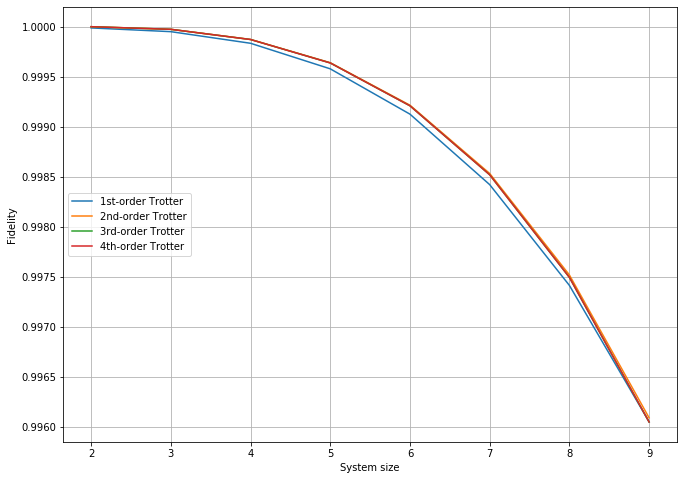

In [22]:
plt.grid(True)
no_of_steps = np.arange(1,101)
plt.plot(np.arange(2,10),fid_qbt_var_1, '-', label='1st-order Trotter')
plt.plot(np.arange(2,10),fid_qbt_var_2, '-', label='2nd-order Trotter')
plt.plot(np.arange(2,10),fid_qbt_var_3, '-', label='3rd-order Trotter')
plt.plot(np.arange(2,10),fid_qbt_var_4, '-', label='4th-order Trotter')
plt.xlabel('System size')
plt.ylabel('Fidelity')
plt.legend(loc = "center left")
#plt.savefig(output_dir+'/fid_vs_qubits_and_time_plots/'
#            +'fid_vs_no_of_qbt_with_simu_t_01', dpi=100)

Explanation for seperation between the first-order and the higher-order Trotter approximants behaving parabolically: initially, when system size is relatively small, the seperation increases because weight of correction terms tends to be more significant than weight of commutators of non-commutative Pauli terms; however, when system size is relatively large, which contributes to a binomially increased number of non-commutative Pauli terms, the seperation then decreases because weight of corrrection terms tends to be overwhelmed by weight of the commutators. This means, in this very situation, that approximation delivered by the higher-order Trotter approximants is asymptotically as poor as that by the first-order.

#### Now we implement coefficient of correlation to investigate the closeness of the Trotter approximants over increased evolution time.

### ${\color{Blue}{\mathit{\text{Part II:}}}}$ Discretization of evolution time.

#### We first set total evolution time t = 1s.

In [23]:
def discre_of_time(n,t,no_of_step):
    '''Definition of a function to implement discretization of time 
       for an Ising chain with Hamiltonian H =
       -0.5*(1/|i-j|)*sigma_x_i*sigma_x_j - 0.5*sigma_x_j - 0.5*sigma_z_j 
       where index i j run from 0th to (n-1)th site and i is always smaller 
       than j. Here 2nd-order Trotter approximant is applied. Function returns
       a wavefunc after evolution time of 1s with no_of_step number of Trotter
       steps implemented. 
       param n: number of qubits (n>=2). 
       param t: total evolution time. 
       param no_of_step: number of Trotter steps.'''
    wavefunction_simulator = WavefunctionSimulator()
    prog_ini = Program()
    prog = Ising_prog_2(n,t/no_of_step)
    for i in np.arange(no_of_step):
        prog_ini += prog
    wavefunc = wavefunction_simulator.wavefunction(prog_ini)
    return wavefunc

In [26]:
interval = [  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100]

In [32]:
n = 9 # system size
t = 1 # evolution time
fid_9qbt_demo_1 = []
theo_9qbt_demo_1 = expm(1j*theo_Hamil(n,t)).dot(ini_state(n))
for i in tqdm_notebook(interval):
    key = fidelity(theo_9qbt_demo_1,np.array(convert_col(discre_of_time(n,t,i),n)))
    fid_9qbt_demo_1 = np.append(fid_9qbt_demo_1,key)

In [38]:
n = 9 # system size
t = 2 # evolution time
fid_9qbt_demo_2 = []
theo_9qbt_demo_2 = expm(1j*theo_Hamil(n,t)).dot(ini_state(n))
for i in tqdm_notebook(interval):
    key = fidelity(theo_9qbt_demo_2,np.array(convert_col(discre_of_time(n,t,i),n)))
    fid_9qbt_demo_2 = np.append(fid_9qbt_demo_2,key)

In [40]:
n = 9 # system size
t = 3 # evolution time
fid_9qbt_demo_3 = []
theo_9qbt_demo_3 = expm(1j*theo_Hamil(n,t)).dot(ini_state(n))
for i in tqdm_notebook(interval):
    key = fidelity(theo_9qbt_demo_3,np.array(convert_col(discre_of_time(n,t,i),n)))
    fid_9qbt_demo_3 = np.append(fid_9qbt_demo_3,key)

In [42]:
n = 9 # system size
t = 4 # evolution time
fid_9qbt_demo_4 = []
theo_9qbt_demo_4 = expm(1j*theo_Hamil(n,t)).dot(ini_state(n))
for i in tqdm_notebook(interval):
    key = fidelity(theo_9qbt_demo_4,np.array(convert_col(discre_of_time(n,t,i),n)))
    fid_9qbt_demo_4 = np.append(fid_9qbt_demo_4,key)

In [ ]:
n = 9 # system size
t = 5 # evolution time
fid_9qbt_demo_5 = []
theo_9qbt_demo_5 = expm(1j*theo_Hamil(n,t)).dot(ini_state(n))
for i in tqdm_notebook(interval):
    key = fidelity(theo_9qbt_demo_5,np.array(convert_col(discre_of_time(n,t,i),n)))
    fid_9qbt_demo_5 = np.append(fid_9qbt_demo_5,key)

In [ ]:
n = 9 # system size
t = 6 # evolution time
fid_9qbt_demo_6 = []
theo_9qbt_demo_6 = expm(1j*theo_Hamil(n,t)).dot(ini_state(n))
for i in tqdm_notebook(interval):
    key = fidelity(theo_9qbt_demo_6,np.array(convert_col(discre_of_time(n,t,i),n)))
    fid_9qbt_demo_6 = np.append(fid_9qbt_demo_6,key)

In [ ]:
n = 9 # system size
t = 7 # evolution time
fid_9qbt_demo_7 = []
theo_9qbt_demo_7 = expm(1j*theo_Hamil(n,t)).dot(ini_state(n))
for i in tqdm_notebook(interval):
    key = fidelity(theo_9qbt_demo_7,np.array(convert_col(discre_of_time(n,t,i),n)))
    fid_9qbt_demo_7 = np.append(fid_9qbt_demo_7,key)

In [ ]:
n = 9 # system size
t = 8 # evolution time
fid_9qbt_demo_8 = []
theo_9qbt_demo_8 = expm(1j*theo_Hamil(n,t)).dot(ini_state(n))
for i in tqdm_notebook(interval):
    key = fidelity(theo_9qbt_demo_8,np.array(convert_col(discre_of_time(n,t,i),n)))
    fid_9qbt_demo_8 = np.append(fid_9qbt_demo_8,key)

In [ ]:
n = 9 # system size
t = 9 # evolution time
fid_9qbt_demo_9 = []
theo_9qbt_demo_9 = expm(1j*theo_Hamil(n,t)).dot(ini_state(n))
for i in tqdm_notebook(interval):
    key = fidelity(theo_9qbt_demo_9,np.array(convert_col(discre_of_time(n,t,i),n)))
    fid_9qbt_demo_9 = np.append(fid_9qbt_demo_9,key)

In [33]:
n = 9 # system size
t = 10 # evolution time
fid_9qbt_demo_10 = []
theo_9qbt_demo_10 = expm(1j*theo_Hamil(n,t)).dot(ini_state(n))
for i in tqdm_notebook(interval):
    key = fidelity(theo_9qbt_demo_10,np.array(convert_col(discre_of_time(n,t,i),n)))
    fid_9qbt_demo_10 = np.append(fid_9qbt_demo_10,key)

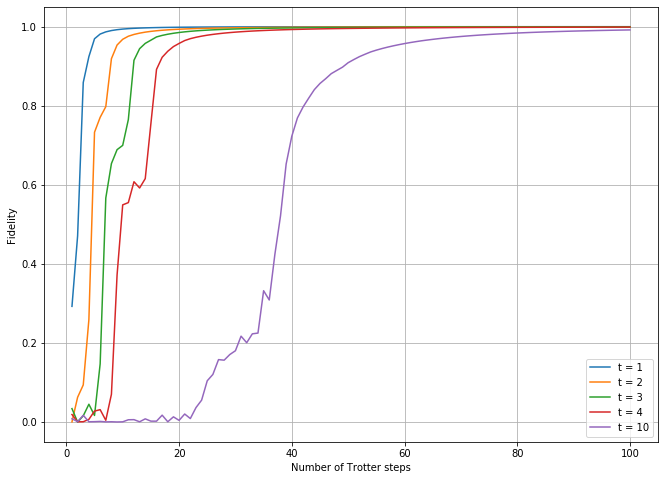

In [43]:
plt.grid(True)
no_of_steps = np.arange(1,101)
plt.plot(no_of_steps, fid_9qbt_demo_1, '-', label = 't = 1')
plt.plot(no_of_steps, fid_9qbt_demo_2, '-', label = 't = 2')
plt.plot(no_of_steps, fid_9qbt_demo_3, '-', label = 't = 3')
plt.plot(no_of_steps, fid_9qbt_demo_4, '-', label = 't = 4')
plt.plot(no_of_steps, fid_9qbt_demo_10, '-', label = 't = 10')
plt.xlabel('Number of Trotter steps')
plt.ylabel('Fidelity')
plt.legend(loc = "lower right")
#plt.savefig(output_dir+'/fid_demo_1_to_100_steps_plots/'
#            +'fid_vs_steps_1to100_simu_t_10', dpi=100)